In [ ]:
!pip install rasterio tqdm


In [ ]:

import os
import rasterio
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from collections import Counter
class TifImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(".tif")]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
    # Load the image using rasterio
      img_name = self.image_names[idx]
      img_path = os.path.join(self.image_dir, img_name)
      with rasterio.open(img_path) as src:
          image = src.read()  # Read all bands

      # Convert image to PyTorch tensor
      image = torch.tensor(image, dtype=torch.float32)

      # Fix NaN values
      for band in range(image.shape[0]):  # Iterate over bands
          band_data = image[band, :, :]
          nan_mask = torch.isnan(band_data)
          if nan_mask.any():
              mean_value = band_data[~nan_mask].mean()  # Mean of non-NaN values
              band_data[nan_mask] = mean_value  # Replace NaN with the mean

      # Ensure 3-channel image for consistency
      if image.shape[0] == 3:
          pass
      elif image.shape[0] > 3:
          image = image[:3, :, :]
      else:
          image = image.expand(3, image.shape[1], image.shape[2])

      # Load the corresponding mask
      mask_name = img_name.replace(".tif", "_mask.tif")
      mask_path = os.path.join(self.mask_dir, mask_name)
      with rasterio.open(mask_path) as src:
          mask = src.read(1)  # Read single channel for binary mask

      # Calculate the number of zeros and non-zeros in the mask
      total_pixels = mask.size  # Total number of pixels in the mask
      non_zero_pixels = (mask > 0).sum()  # Count of non-zero pixels
      non_zero_percentage = (non_zero_pixels / total_pixels) * 100

      # Determine label based on non-zero percentage
      label = torch.tensor(1 if non_zero_percentage > 30 else 0, dtype=torch.long)

      # Apply transforms if provided
      if self.transform:
          image = self.transform(image)

      return image, label


In [ ]:
from torchvision.transforms import Compose, Normalize, Resize

# Define transformations with augmentations
input_size = 224  # Required input size for ViT
transform = Compose([
    Resize((input_size, input_size)),            # Resize to ViT-compatible dimensions
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))     # ImageNet normalization
])

# Initialize dataset
image_dir = "sar-ds-r-filtered-bal/sar_ds_r_filtered_bal/image_patches"
mask_dir = "sar-ds-r-filtered-bal/sar_ds_r_filtered_bal/mask_patches"
dataset = TifImageDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)

# Example to check output
for image, label in dataset:
    print(f"Image shape before processing: {image.shape}, Label: {label}")
    break

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset,ConcatDataset
import numpy as np
# Separate the dataset into two subsets based on labels (0 and 1)
label_0_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]
label_1_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]

# Random split for label 0

Image shape before processing: torch.Size([3, 224, 224]), Label: 1


In [3]:
from torch.utils.data import Subset,ConcatDataset
train_indices_0, val_indices_0 = train_test_split(
    label_0_indices, test_size=0.2, random_state=42
)

# Random split for label 1
train_indices_1, val_indices_1 = train_test_split(
    label_1_indices, test_size=0.2, random_state=42
)

# Create subsets for training and validation
train_subset_0 = Subset(dataset, train_indices_0)
train_subset_1 = Subset(dataset, train_indices_1)
val_subset_0 = Subset(dataset, val_indices_0)
val_subset_1 = Subset(dataset, val_indices_1)

# Merge training and validation subsets
train_dataset = ConcatDataset([train_subset_0, train_subset_1])
val_dataset = ConcatDataset([val_subset_0, val_subset_1])

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

#print(f"Training samples: {train_size}, Validation samples: {val_size}")

for image, label in train_loader:
    print(f"Image shape after processing: {image.shape}, Label: {label}")
    break
print(torch.cuda.is_available())
print(torch.version.cuda)

Image shape after processing: torch.Size([8, 3, 224, 224]), Label: tensor([0, 0, 0, 0, 1, 0, 0, 0])
True
12.1


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 256)  # Adjusted for input size after convolutions and pooling
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # Output for 10 classes (adjust as needed)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 28 * 28)

        # Fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer (no activation for logits)

        return x

# Initialize the model
model = CNNModel()

# Print the model architecture
print(model)

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import os
import pickle
import torch
from collections import Counter
from torchvision import models
from tqdm import tqdm
from timm import create_model
from torch import nn, optim
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error
import pandas as pd

# Enable DataParallel for multi-GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs...")
    model = torch.nn.DataParallel(model)

model.to(device)

# Check class distribution
class_counts = Counter(label.item() for _, label in dataset)
print(f"Class distribution: {class_counts}")

class_weights = torch.tensor([1.0, len(dataset) / class_counts[1]], device=device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8)

# Initialize lists to store metrics
metrics_history = []
checkpoint_dir = ""
#os.makedirs(checkpoint_dir, exist_ok=True)  # Create directory if it doesn't exist
metrics_csv_path = os.path.join(checkpoint_dir, "metrics_history_filtered_CNN.csv")

best_val = 0.0  # To track the best model
best_train = 0.0 
# Training loop with checkpoint saving
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")
    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "Batch Loss": f"{loss.item():.4f}",
            "Batch Accuracy": f"{100 * correct / total:.2f}%"
        })

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_labels = []
    all_val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_val_labels.extend(labels.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_precision = precision_score(all_val_labels, all_val_predictions, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_predictions, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')

    # Save metrics
    metrics_history.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_f1_score": val_f1,
    })

    metrics_df = pd.DataFrame(metrics_history)
    metrics_df.to_csv(metrics_csv_path, index=False)

    print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.2f}, "
          f"Val Recall: {val_recall:.2f}, Val F1 Score: {val_f1:.2f}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val:
        best_accuracy = val_accuracy
        best_model_path = os.path.join(checkpoint_dir, "best_model_filtered_CNN_val.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_accuracy,
        }, best_model_path)
        print(f"Best model updated with validation accuracy: {best_accuracy:.2f}%")
    if train_accuracy > best_train:
        best_accuracy = train_accuracy
        best_model_path = os.path.join(checkpoint_dir, "best_model_filtered_CNN.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': train_accuracy,
        }, best_model_path)
        print(f"Best model updated with train accuracy: {best_accuracy:.2f}%")

print("Training complete. Checkpoints and metrics saved.")


Using 2 GPUs...
Class distribution: {1: 3496, 0: 3496}


Epoch 1/15: 100%|██████████| 699/699 [01:08<00:00, 10.14it/s, Batch Loss=0.8825, Batch Accuracy=49.09%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/15] - Train Loss: 0.7842, Train Accuracy: 49.09%, Val Loss: 0.8514, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 49.09%


Epoch 2/15: 100%|██████████| 699/699 [01:04<00:00, 10.80it/s, Batch Loss=0.6538, Batch Accuracy=50.30%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/15] - Train Loss: 0.7632, Train Accuracy: 50.30%, Val Loss: 0.8316, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 50.30%


Epoch 3/15: 100%|██████████| 699/699 [01:04<00:00, 10.80it/s, Batch Loss=0.8193, Batch Accuracy=50.77%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/15] - Train Loss: 0.7377, Train Accuracy: 50.77%, Val Loss: 0.8257, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 50.77%


Epoch 4/15: 100%|██████████| 699/699 [01:04<00:00, 10.77it/s, Batch Loss=0.7780, Batch Accuracy=49.54%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/15] - Train Loss: 0.7347, Train Accuracy: 49.54%, Val Loss: 0.8260, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 49.54%


Epoch 5/15: 100%|██████████| 699/699 [01:04<00:00, 10.76it/s, Batch Loss=0.7347, Batch Accuracy=49.41%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/15] - Train Loss: 0.7255, Train Accuracy: 49.41%, Val Loss: 0.8085, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 49.41%


Epoch 6/15: 100%|██████████| 699/699 [01:04<00:00, 10.80it/s, Batch Loss=1.3576, Batch Accuracy=51.13%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/15] - Train Loss: 0.7014, Train Accuracy: 51.13%, Val Loss: 0.7715, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 51.13%


Epoch 7/15: 100%|██████████| 699/699 [01:05<00:00, 10.71it/s, Batch Loss=0.8944, Batch Accuracy=50.23%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/15] - Train Loss: 0.7077, Train Accuracy: 50.23%, Val Loss: 0.7655, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 50.23%


Epoch 8/15: 100%|██████████| 699/699 [01:05<00:00, 10.69it/s, Batch Loss=0.4660, Batch Accuracy=50.95%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/15] - Train Loss: 0.6915, Train Accuracy: 50.95%, Val Loss: 0.7490, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 50.95%


Epoch 9/15: 100%|██████████| 699/699 [01:09<00:00, 10.08it/s, Batch Loss=0.5342, Batch Accuracy=50.36%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/15] - Train Loss: 0.6867, Train Accuracy: 50.36%, Val Loss: 0.7446, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 50.36%


Epoch 10/15: 100%|██████████| 699/699 [01:11<00:00,  9.79it/s, Batch Loss=0.5965, Batch Accuracy=50.89%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/15] - Train Loss: 0.6811, Train Accuracy: 50.89%, Val Loss: 0.7397, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 50.89%


Epoch 11/15: 100%|██████████| 699/699 [01:09<00:00, 10.03it/s, Batch Loss=0.6155, Batch Accuracy=50.09%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/15] - Train Loss: 0.6855, Train Accuracy: 50.09%, Val Loss: 0.7302, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 50.09%


Epoch 12/15: 100%|██████████| 699/699 [01:06<00:00, 10.57it/s, Batch Loss=0.6816, Batch Accuracy=51.61%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/15] - Train Loss: 0.6654, Train Accuracy: 51.61%, Val Loss: 0.7225, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 51.61%


Epoch 13/15: 100%|██████████| 699/699 [01:05<00:00, 10.73it/s, Batch Loss=0.6478, Batch Accuracy=51.20%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/15] - Train Loss: 0.6703, Train Accuracy: 51.20%, Val Loss: 0.7178, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 51.20%


Epoch 14/15: 100%|██████████| 699/699 [01:08<00:00, 10.26it/s, Batch Loss=0.6902, Batch Accuracy=52.09%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/15] - Train Loss: 0.6606, Train Accuracy: 52.09%, Val Loss: 0.7209, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 52.09%


Epoch 15/15: 100%|██████████| 699/699 [01:05<00:00, 10.72it/s, Batch Loss=0.6329, Batch Accuracy=50.91%]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/15] - Train Loss: 0.6654, Train Accuracy: 50.91%, Val Loss: 0.7206, Val Accuracy: 50.00%, Val Precision: 0.25, Val Recall: 0.50, Val F1 Score: 0.33
Best model updated with validation accuracy: 50.00%
Best model updated with train accuracy: 50.91%
Training complete. Checkpoints and metrics saved.


Confusion Matrix:
[[   0 2796]
 [   0 2796]]

Classification Report:
              precision    recall  f1-score   support

no oil spill       0.00      0.00      0.00      2796
   oil spill       0.50      1.00      0.67      2796

    accuracy                           0.50      5592
   macro avg       0.25      0.50      0.33      5592
weighted avg       0.25      0.50      0.33      5592

Precision: 0.50
Recall (Sensitivity, TPR): 1.00
F1 Score: 0.67
Cohen's Kappa: 0.00
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.00
False Positive Rate (FPR): 1.00
False Negative Rate (FNR): 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


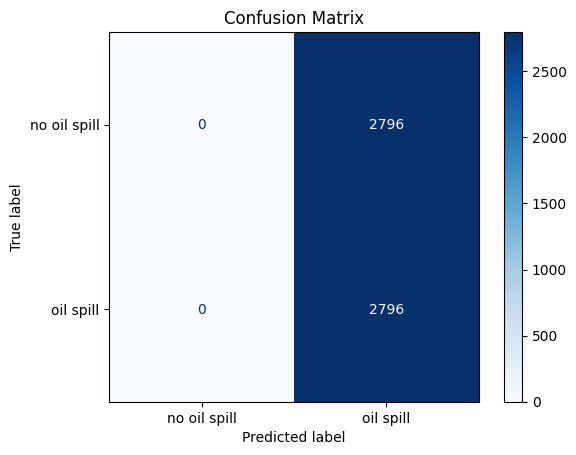

In [8]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    classification_report
)
import matplotlib.pyplot as plt

# Step 2: Evaluate and Collect Predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 3: Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['no oil spill', 'oil spill']  # Replace with your class names if needed

# Extract True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Metrics Calculations
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
kappa = cohen_kappa_score(all_labels, all_preds)
TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # True Positive Rate (Sensitivity)
TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate (Specificity)
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  # False Negative Rate

# Display Metrics
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity, TPR): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"True Negative Rate (TNR): {TNR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"False Negative Rate (FNR): {FNR:.2f}")

# Step 4: Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
